# Estimate fluxes

This will take you through the process of extracting flux information from a given transport operator.
It is split into 3 parts
1. Figure out the stencil of the operator
2. Partition the operator according to said stencil
3. Estimate the flux of a given 3D tracer field

Let's start telling Julia we will be using AIBECS and Plots.

In [1]:
using AIBECS, Plots

## 1. Operator stencil

Let's load the OCCA grid information `grd` and transport matrix $\mathbf{T}$ (the variable `T` here).

In [2]:
grd, T = OCCA.load()

┌ Info: You are about to use the OCCA model.
│ If you use it for research, please cite:
│ 
│ - Forget, G., 2010: Mapping Ocean Observations in a Dynamical Framework: A 2004–06 Ocean Atlas. J. Phys. Oceanogr., 40, 1201–1221, https://doi.org/10.1175/2009JPO4043.1
│ 
│ You can find the corresponding BibTeX entries in the CITATION.bib file
│ at the root of the AIBECS.jl package repository.
│ (Look for the "Forget_2010" key.)
└ @ AIBECS.OCCA /Users/runner/work/AIBECS.jl/AIBECS.jl/src/OCCA.jl:84


(, 
  [1    ,     1]  =  2.28272e-7
  [2    ,     1]  =  1.80306e-10
  [9551 ,     1]  =  -2.20276e-7
  [9606 ,     1]  =  -1.66979e-8
  [1    ,     2]  =  -8.32821e-8
  [2    ,     2]  =  3.64559e-7
  [3    ,     2]  =  -2.43459e-8
  [57   ,     2]  =  2.34627e-8
  [9552 ,     2]  =  -3.29498e-7
  ⋮
  [79928, 84660]  =  -2.33777e-8
  [84632, 84660]  =  -1.08539e-8
  [84659, 84660]  =  -2.48014e-8
  [84660, 84660]  =  7.65894e-8
  [84661, 84660]  =  -2.49411e-8
  [79891, 84661]  =  -2.27883e-9
  [79929, 84661]  =  -3.38614e-8
  [84633, 84661]  =  -2.05398e-8
  [84660, 84661]  =  -1.81939e-8
  [84661, 84661]  =  5.86467e-8)

Multiplying $\mathbf{T}$ with a given tracer concentration vector $\boldsymbol{x}$ gives the flux-divergence of that tracer.
In other words, $\mathbf{T}$ operates on $\boldsymbol{x}$ by exchanging tracers between model-grid boxes.
But $\mathbf{T}$ only operates on *neighboring* grid boxes.
I.e., $\mathbf{T}$ usually does not directly exchange tracers between boxes far away from each other.

AIBECS provides a function, `stencil`, that returns all the relative cartesian indices (AKA the relative sub-indices) of the neighbors used by a given operator.
In the case of OCCA, the stencil is thus

In [3]:
st = stencil(T, grd)

7-element Array{CartesianIndex{3},1}:
 CartesianIndex(0, 0, 0)
 CartesianIndex(-1, 0, 0)
 CartesianIndex(0, 1, 0)
 CartesianIndex(0, 0, -1)
 CartesianIndex(1, 0, 0)
 CartesianIndex(0, -1, 0)
 CartesianIndex(0, 0, 1)

There is also a `label` function to, well, label the stencil elements in a more human-readable way.
(Note `label` is not exported, so you must specify that it comes from the `AIBECS` package, as below.)

In [4]:
[st AIBECS.label.(st)]

7×2 Array{Any,2}:
 CartesianIndex(0, 0, 0)   ""
 CartesianIndex(-1, 0, 0)  "South"
 CartesianIndex(0, 1, 0)   "East"
 CartesianIndex(0, 0, -1)  "Above"
 CartesianIndex(1, 0, 0)   "North"
 CartesianIndex(0, -1, 0)  "West"
 CartesianIndex(0, 0, 1)   "Below"

The stencil can be visualized with the `plotstencil` recipe

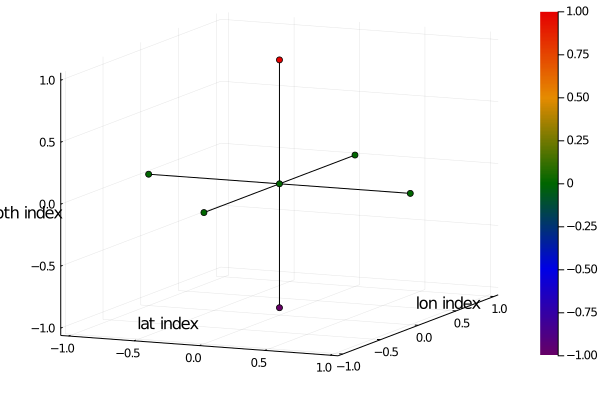

In [5]:
plotstencil(st)

> Note:
> In fact, the continuous equivalent of the matrix $\mathbf{T}$, i.e., the flux-divergence operator $\mathcal{T}$ is a differential operator, which is local by definition.
> It is the spatial discretization of the differential operators that imposes the use of neighboring boxes to estimate spatial gradients.

This works for any circulation, so you can swap `grd` and `T` and try again... Here we plot the same figure for a few different circulations available in AIBECS.

┌ Warning: Assignment to `grd` in soft scope is ambiguous because a global variable by the same name exists: `grd` will be treated as a new local. Disambiguate by using `local grd` to suppress this warning or `global grd` to assign to the existing global variable.
└ @ nothing string:3
┌ Warning: Assignment to `T` in soft scope is ambiguous because a global variable by the same name exists: `T` will be treated as a new local. Disambiguate by using `local T` to suppress this warning or `global T` to assign to the existing global variable.
└ @ nothing string:3
┌ Info: You are about to use the OCIM0.1 model.
│ If you use it for research, please cite:
│ 
│ - Primeau, F. W., Holzer, M., and DeVries, T. (2013), Southern Ocean nutrient trapping and the efficiency of the biological pump, J. Geophys. Res. Oceans, 118, 2547–2564, doi:10.1002/jgrc.20181.
│ - DeVries, T. and F. Primeau, 2011: Dynamically and Observationally Constrained Estimates of Water-Mass Distributions and Ages in the Global Oc

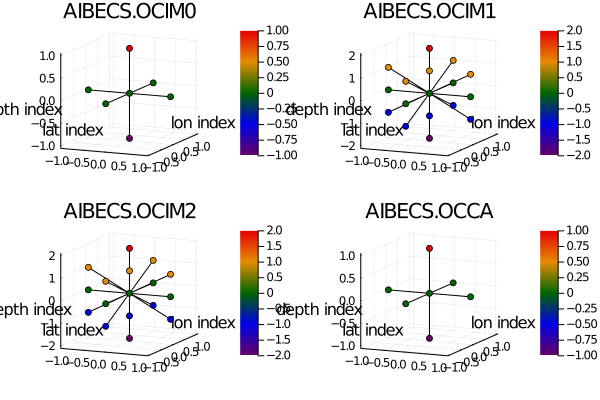

In [6]:
plts = Any[]
for Circulation in [OCIM0, OCIM1, OCIM2, OCCA]
    grd, T = Circulation.load()
    push!(plts, plotstencil(stencil(grd, T), title=string(Circulation)))
end
plot(plts..., layout=(2,2))

These stencils are useful to clarify the origin and destination of tracer fluxes we are going to explore in this guide..

## 2. Operator Partition

For a given operator $\mathbf{T}$, to each point (or neighbor) $k$ in its stencil corresponds a unique transport operator $\mathbf{T}_k$, which effectively performs the transfer of tracers from that neighbor.
In other words, if the stencil has $n$ elements, $\mathbf{T}$ can be partitionned into a family of $n-1$ matrices $\mathbf{T}_k$ that each operate in a single direction of the stencil.

Let's take the "West" neighbor of the OCCA stencil

In [7]:
dir = st[findfirst(AIBECS.label.(st) .== "West")]

CartesianIndex(0, -1, 0)

The AIBECS provides a function `directional_T` that returns the transport operator corresponding to the direction provided from the stencil element.

In [8]:
T_West = directional_transport(T, grd, dir)

84661×84661 SparseMatrixCSC{Float64,Int64} with 161878 stored entries:
  [1    ,     1]  =  2.20276e-7
  [2    ,     2]  =  3.29498e-7
  [57   ,     2]  =  2.34627e-8
  [3    ,     3]  =  2.74657e-7
  [58   ,     3]  =  2.01594e-8
  [4    ,     4]  =  1.7713e-7
  [59   ,     4]  =  -5.07317e-8
  [5    ,     5]  =  1.51141e-7
  [60   ,     5]  =  -4.28847e-8
  ⋮
  [79925, 84657]  =  -2.55804e-8
  [84657, 84657]  =  -1.06738e-8
  [79926, 84658]  =  -9.70215e-8
  [84658, 84658]  =  -2.26404e-8
  [79927, 84659]  =  -3.6755e-8
  [84659, 84659]  =  1.88837e-9
  [79928, 84660]  =  -2.33777e-8
  [84660, 84660]  =  1.31811e-8
  [79929, 84661]  =  -3.38614e-8
  [84661, 84661]  =  1.60238e-8

Notice how `T_West` only has nonzeros on the main diagonal and on one off-diagonal, that connect each box index with the index of the box "West" of it.

## 3. Flux Estimate

We can look at the depth-integrated mean flux of a fictitious tracer $\boldsymbol{x}$ of concentration 1 mol m⁻³ coming from the west by computing and plotting the vertical integral of $-\mathbf{T}\boldsymbol{x}$:

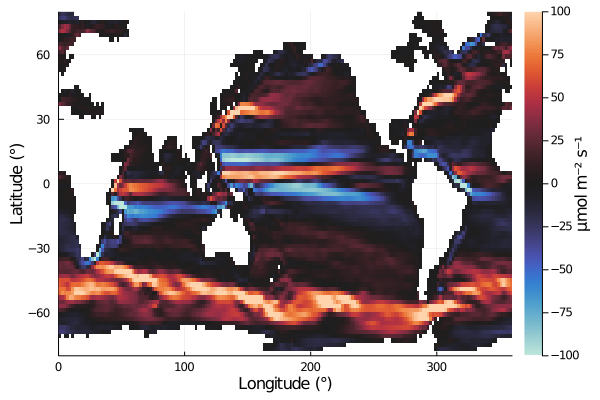

In [9]:
nwet = count(iswet(grd))
x = ones(nwet)
plotverticalintegral(-T_West * x * u"mol/m^3/s" .|> u"μmol/m^3/s", grd, mask=depthvec(grd) .< 100, color=:seaborn_icefire_gradient, clim=1e2 .* (-1,1))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*